In [1]:
import os
import matplotlib.pyplot as plt

import numpy as np
import astropy.units as u
from astropy.time import Time
import pytz

from astropy.table import QTable

from astroplan.plots import plot_airmass
from astroplan import Observer, FixedTarget, time_grid_from_range

from pathlib import Path
from astropy.nddata import CCDData
from astropy.io import fits
from ccdproc import ImageFileCollection
import ccdproc

from astropy.modeling import models
from astropy import nddata

import photutils
from photutils.aperture import CircularAperture
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from photutils.datasets import load_star_image

from astropy.visualization import SqrtStretch, ZScaleInterval
from astropy.visualization.mpl_normalize import ImageNormalize

from photutils.aperture import CircularAnnulus, aperture_photometry

import warnings
warnings.simplefilter('ignore')

In [2]:
r_images = Path('/home/jovyan/A480_fixed_reduced_r_data')
g_images = Path('/home/jovyan/A480_reduced_g_data')

In [3]:
r_collection = ImageFileCollection(r_images)
g_collection = ImageFileCollection(g_images)
r_collection.summary['file', 'imagetyp', 'object']

<Table length=35>
                     file                      imagetyp   object 
                    str46                        str5      str9  
---------------------------------------------- -------- ---------
 fixed_reduced_HV_UMa_5_r_20240508_062607.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_063017.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_063037.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_064441.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_064505.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_072008.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_072030.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_072049.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_073407.fits    LIGHT  HV_UMa_5
 fixed_reduced_HV_UMa_5_r_20240508_073430.fits    LIGHT  HV_UMa_5
                                           ...      ...       ...
fixed_reduced_HY_Com_20_r_20240508_073156.fits    LIGHT HY_Com_20
fixed_reduced_TU_UMa_20_r_20240508_070527.fits    LIGHT TU_UMa_20
fixed_reduced_TU_UMa_20_r_20240508_070604.fits    LIGHT TU_UMa_20
fixed_reduced_TU_UMa_20_r_20240508_070637.fits    LIGHT TU_UMa_20
fixed_reduced_TU_UMa_20_r_20240508_072256.fits    LIGHT TU_UMa_20
fixed_reduced_TU_UMa_20_r_20240508_072337.fits    LIGHT TU_UMa_20
fixed_reduced_TU_UMa_20_r_20240508_072417.fits    LIGHT TU_UMa_20
fixed_reduced_TU_Uma_20_r_20240508_064737.fits    LIGHT TU_Uma_20
fixed_reduced_TU_Uma_20_r_20240508_064812.fits    LIGHT TU_Uma_20
fixed_reduced_TU_Uma_20_r_20240508_064844.fits    LIGHT TU_Uma_20

In [4]:
#only using 5 exposure for HV
r_HV_UMa = []
for star, fname in r_collection.hdus(object = 'HV_UMa_5' or 'HV_Uma_5', return_fname = True):
    meta = star.header
    meta['filename'] = fname
    r_HV_UMa.append(ccdproc.CCDData(data=star.data, meta=meta, unit = 'adu'))

r_HY_Com = []
for star, fname in r_collection.hdus(object = 'HY_Com_20', return_fname = True):
    meta = star.header
    meta['filename'] = fname
    r_HY_Com.append(ccdproc.CCDData(data=star.data, meta=meta, unit = 'adu'))

r_TU_UMa = []
for star, fname in r_collection.hdus(object = 'TU_UMa_20' or 'TU_Uma_20', return_fname = True):
    meta = star.header
    meta['filename'] = fname
    r_TU_UMa.append(ccdproc.CCDData(data=star.data, meta=meta, unit = 'adu'))

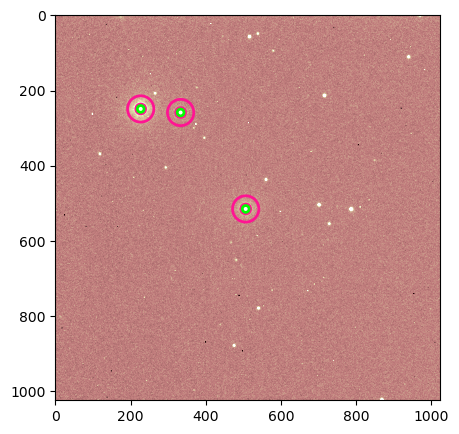

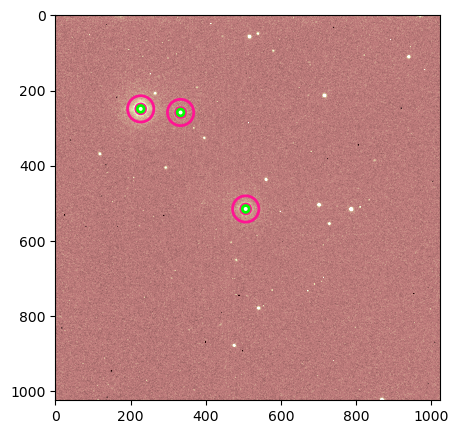

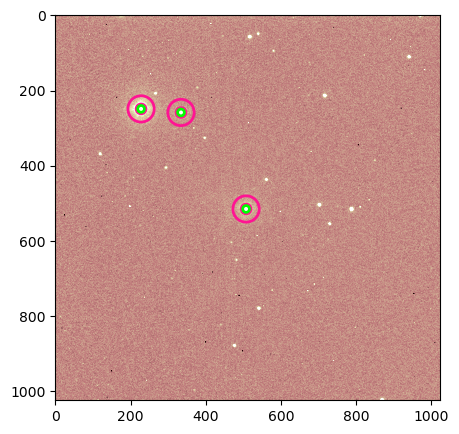

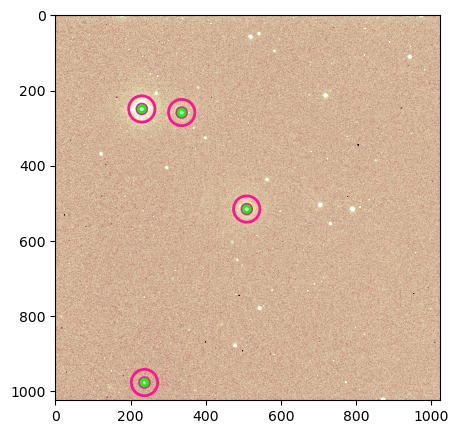

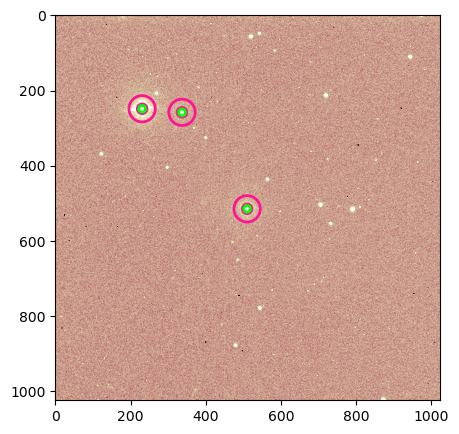

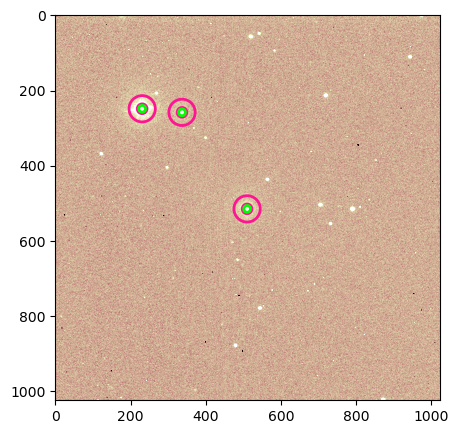

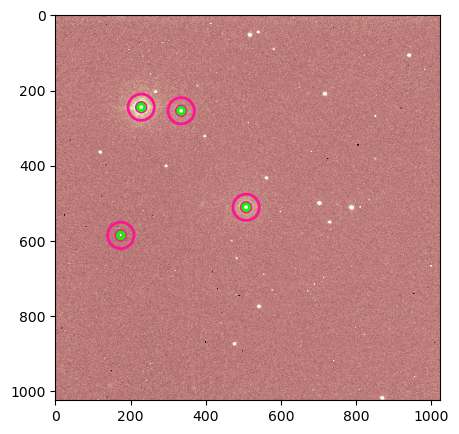

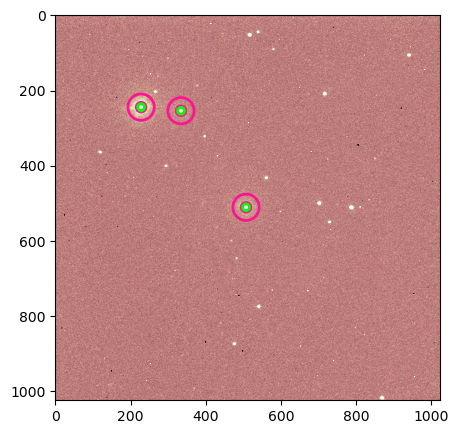

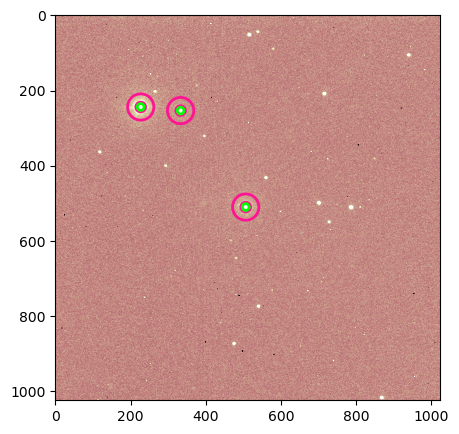

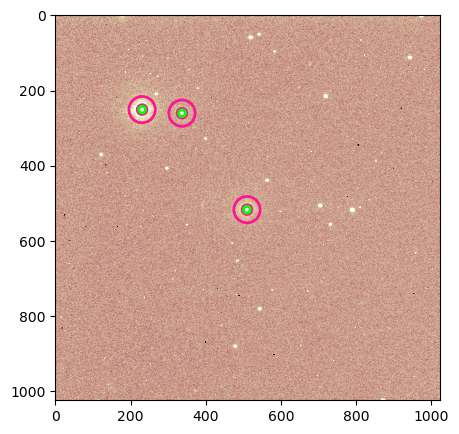

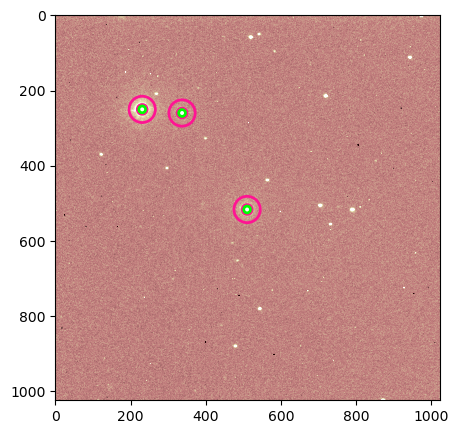

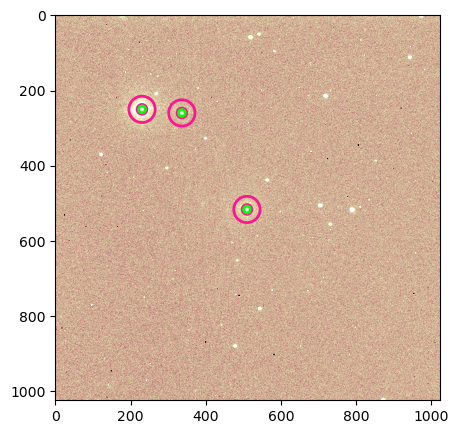

In [5]:
#changing the DAOStarFinder threshold to 50*std to simplify to 2-3 sources
for star in r_HY_Com:
    mean, median, std = sigma_clipped_stats(star, sigma = 3.0)
    znorm = ImageNormalize(star, interval = ZScaleInterval())
    daofind = DAOStarFinder(fwhm = 3.0, threshold = 81.0*std)
    sources = daofind(np.asarray(star) - median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    annulus = CircularAnnulus(positions, r_in = 13, r_out = 35)
    apertures = CircularAperture(positions, r=9)
    plt.figure(figsize = (5, 5))
    annulus.plot(color = 'deeppink', linewidth = 2)
    apertures.plot(color='lime', linewidth = 2)
    plt.imshow(star, norm=znorm, cmap = 'pink')

In [6]:
r_HV_UMa_fluxes = []
r_HY_Com_fluxes = []
r_TU_UMa_fluxes = []

In [7]:
for star in r_HV_UMa:
    #replicating the plot stuff
    mean, median, std = sigma_clipped_stats(star, sigma = 3.0)
    daofind = DAOStarFinder(fwhm = 3.0, threshold = 80.0*std)
    sources = daofind(np.asarray(star) - median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    annulus = CircularAnnulus(positions, r_in = 13, r_out = 35)
    apertures = CircularAperture(positions, r=9)
    total_sky = aperture_photometry(star, annulus)['aperture_sum']
    avg_sky = total_sky / annulus.area
    sky_list = avg_sky * apertures.area

    phot_table = aperture_photometry(star, apertures)
    source_list = phot_table['aperture_sum']
    annulus_fluxes = source_list - sky_list
    r_HV_UMa_fluxes.append(annulus_fluxes)

In [8]:
r_HV_UMa_fluxes

[<Quantity [ 50471.54250112, 607493.66910545] adu>,
 <Quantity [ 50154.37489253, 612776.0323806 ] adu>,
 <Quantity [ 50252.72777186, 615129.82190505] adu>,
 <Quantity [ 49922.35433032, 601093.07357978,   3046.62413146] adu>,
 <Quantity [ 49240.95600279, 594153.43680878] adu>,
 <Quantity [ 47808.2346777 , 599561.86176993] adu>,
 <Quantity [ 49262.64911702, 607952.84463552] adu>,
 <Quantity [ 48630.88310782, 602516.89548135] adu>,
 <Quantity [ 53904.38850476,  46361.2130828 , 597901.2608612 ] adu>,
 <Quantity [ 55565.2136662 ,  48353.81255625, 590152.38579248] adu>,
 <Quantity [ 55134.33489915,  47136.81371706, 593408.73631526] adu>]

In [9]:
r_HV_UMa_variable = []
i=0
while i <=7:
    r_HV_UMa_variable.append(r_HV_UMa_fluxes[i][1].value)
    i+=1


In [10]:
r_HV_UMa_variable.append(597901.2608612)
r_HV_UMa_variable.append(590152.38579248)
r_HV_UMa_variable.append(593408.73631526)

In [11]:
r_HV_UMa_ref = []
i=0
while i <=7: 
    r_HV_UMa_ref.append(r_HV_UMa_fluxes[i][0].value)
    i+=1
r_HV_UMa_ref.append(46361.2130828)
r_HV_UMa_ref.append(48353.81255625)
r_HV_UMa_ref.append(47136.81371706)

In [12]:
r_HV_UMa_ref_alt = []
i=0
while i <=7: 
    r_HV_UMa_ref_alt.append(r_HV_UMa_fluxes[i][0].value)
    i+=1
r_HV_UMa_ref_alt.append(53904.38850476)
r_HV_UMa_ref_alt.append(55565.2136662)
r_HV_UMa_ref_alt.append(55134.33489915)

In [13]:
for star in r_HY_Com:
    #replicating the plot stuff
    mean, median, std = sigma_clipped_stats(star, sigma = 3.0)
    daofind = DAOStarFinder(fwhm = 3.0, threshold = 160.0*std)
    sources = daofind(np.asarray(star) - median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    annulus = CircularAnnulus(positions, r_in = 13, r_out = 35)
    apertures = CircularAperture(positions, r=9)
    total_sky = aperture_photometry(star, annulus)['aperture_sum']
    avg_sky = total_sky / annulus.area
    sky_list = avg_sky * apertures.area

    phot_table = aperture_photometry(star, apertures)
    source_list = phot_table['aperture_sum']
    annulus_fluxes = source_list - sky_list
    r_HY_Com_fluxes.append(annulus_fluxes)

In [14]:
r_HY_Com_fluxes

[<Quantity [1331420.36750754,  237407.45359786,  627331.73160158] adu>,
 <Quantity [1344420.77906549,  236139.89662001,  637439.64979867] adu>,
 <Quantity [1347788.76527825,  240349.7284211 ,  634488.64553644] adu>,
 <Quantity [1328222.73811398,  236114.89305075,  646255.81975328] adu>,
 <Quantity [1334106.04334159,  237902.84819833,  648694.45273902] adu>,
 <Quantity [1322668.911897  ,  239090.12964798,  642450.01533931] adu>,
 <Quantity [1308078.63256387,  234463.02395664,  639480.16941136] adu>,
 <Quantity [1312355.19162651,  232877.97293989,  637772.79638918] adu>,
 <Quantity [1326137.72976035,  237539.32224278,  639362.71374333] adu>,
 <Quantity [1302766.08345462,  236458.38695402,  629326.87351317] adu>,
 <Quantity [1304277.3639859 ,  234502.57234984,  628890.16001531] adu>,
 <Quantity [1310171.26807541,  233847.47568898,  626689.10021226] adu>]

In [15]:
r_HY_Com_variable = []
for star in r_HY_Com_fluxes:
    r_HY_Com_variable.append(star[2].value)

In [16]:
r_HY_Com_variable

[627331.7316015774,
 637439.6497986701,
 634488.6455364404,
 646255.8197532808,
 648694.4527390203,
 642450.015339312,
 639480.1694113555,
 637772.7963891813,
 639362.7137433342,
 629326.8735131731,
 628890.1600153095,
 626689.1002122606]

In [17]:
r_HY_Com_ref = []
for star in r_HY_Com_fluxes:
    r_HY_Com_ref.append(star[1].value)

In [18]:
for star in r_TU_UMa:
    #replicating the plot stuff
    mean, median, std = sigma_clipped_stats(star, sigma = 3.0)
    daofind = DAOStarFinder(fwhm = 3.0, threshold = 250.0*std)
    sources = daofind(np.asarray(star) - median)
    positions = np.transpose((sources['xcentroid'], sources['ycentroid']))

    annulus = CircularAnnulus(positions, r_in = 13, r_out = 35)
    apertures = CircularAperture(positions, r=9)
    total_sky = aperture_photometry(star, annulus)['aperture_sum']
    avg_sky = total_sky / annulus.area
    sky_list = avg_sky * apertures.area

    phot_table = aperture_photometry(star, apertures)
    source_list = phot_table['aperture_sum']
    annulus_fluxes = source_list - sky_list
    r_TU_UMa_fluxes.append(annulus_fluxes)

In [19]:
r_TU_UMa_fluxes

[<Quantity [ 312382.68931625,  798256.13648905, 1541105.73744096] adu>,
 <Quantity [ 314577.07425581,  797609.61757604, 1546352.70064433] adu>,
 <Quantity [ 309607.76232012,  801693.56285028, 1525412.17761388] adu>,
 <Quantity [ 300283.51469301,  767019.1805915 , 1481379.27846453] adu>,
 <Quantity [ 304516.67473954,  773206.52257838, 1508148.05062973] adu>,
 <Quantity [ 305245.02488655,  761512.07164254, 1517504.48352593] adu>,
 <Quantity [ 314948.10164876,  818349.58081976, 1537166.6159968 ] adu>,
 <Quantity [ 314257.02638813,  821422.86345978, 1536341.77169422] adu>,
 <Quantity [ 311617.11476664,  810874.84385129, 1549183.90107729] adu>]

In [20]:
r_TU_UMa_variable = []
for star in r_TU_UMa_fluxes:
    r_TU_UMa_variable.append(star[2].value)

In [21]:
r_TU_UMa_ref = []
for star in r_TU_UMa_fluxes:
    r_TU_UMa_ref.append(star[0].value)

In [22]:
r_TU_UMa_variable

[1541105.7374409635,
 1546352.7006443322,
 1525412.1776138814,
 1481379.2784645266,
 1508148.0506297313,
 1517504.4835259276,
 1537166.6159967983,
 1536341.771694215,
 1549183.9010772891]

In [23]:
r_HV_UMa[0].header['JD']

2460438.768181829

In [24]:
#making time list, must be in julian date or wont work...sad!
HV_times = []
for star in r_HV_UMa:
    HV_times.append(star.header['JD'])

In [25]:
TU_times = []
for star in r_TU_UMa:
    TU_times.append(star.header['JD'])

In [26]:
HY_times = []
for star in r_HY_Com:
    HY_times.append(star.header['JD'])

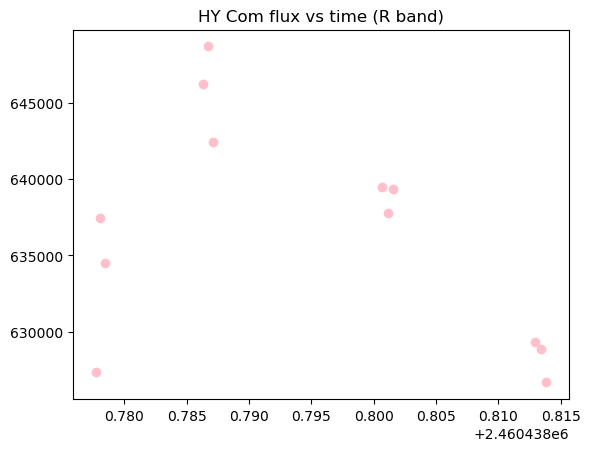

In [27]:
plt.scatter(HY_times, r_HY_Com_variable, c = 'pink')
#plt.plot(HY_times, r_HY_Com_variable, c = 'pink')

#plt.scatter(HY_times, r_HY_Com_ref, c = 'blue')
#plt.plot(HY_times, r_HY_Com_ref, c = 'blue')


#plt.yscale('log')
plt.title('HY Com flux vs time (R band)')
plt.show()

In [28]:
#r_HV_UMa_variable_norm = r_HV_UMa_variable - r_HV_UMa_ref
j = 0
for item in r_HV_UMa_variable:
    item - r_HV_UMa_ref[j]
    j+=1

In [29]:
len(r_HV_UMa_variable)

11

In [30]:
print(np.polyfit(HV_times, r_HV_UMa_variable, 1))

[-2.74159922e+05  6.74554309e+11]


In [32]:
HV_times
HV_times_mod = []
for item in HV_times:
    newest_guy = item - 2460438
    HV_times_mod.append(newest_guy)

In [33]:
dummy_y = []
for item in HV_times_mod:
    this_guy = (-250000) * (item - (0.80)) +int(601000)
    dummy_y.append(this_guy)

In [34]:
dummy_y

[608954.5428045094,
 608230.121572502,
 608182.4073558673,
 605720.9490323439,
 605672.62736056,
 599579.6006396413,
 599522.6273303851,
 599466.7534474283,
 597153.2407207415,
 597093.518496491,
 597035.8506534249]

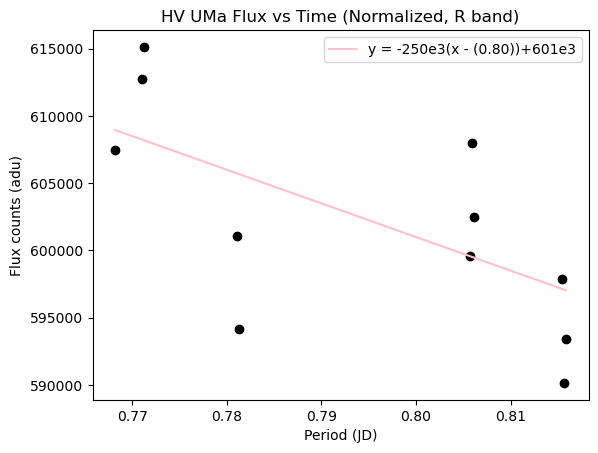

In [159]:
plt.scatter(HV_times_mod, r_HV_UMa_variable, c = 'black')
#plt.plot(HV_times, r_HV_UMa_variable, c = 'pink')

#plt.scatter(HV_times, r_HV_UMa_ref_alt, c = 'blue')
#plt.plot(HV_times, r_HV_UMa_ref_alt, c = 'blue')

#plt.scatter(HV_times, r_HV_UMa_ref, c = 'green')
#plt.plot(HV_times, r_HV_UMa_ref, c = 'green')

plt.plot(HV_times_mod, dummy_y, c = 'pink', label = 'y = -250e3(x - (0.80))+601e3')

#plt.yscale('log')
plt.title('HV UMa Flux vs Time (Normalized, R band)')
plt.xlabel('Period (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend()
plt.show()

In [36]:
from scipy import optimize

In [37]:
def test_func(x, a, b):
    return a * np.sin(b * x)

params, params_covariance = optimize.curve_fit(test_func, HV_times, r_HV_UMa_variable, p0=[2, 2])

print(params)

[-6.16658265e+05  2.12106967e+00]


In [38]:
HV_test_func = test_func(HV_times, params[0], 2)
HV_fit = HV_test_func.tolist()

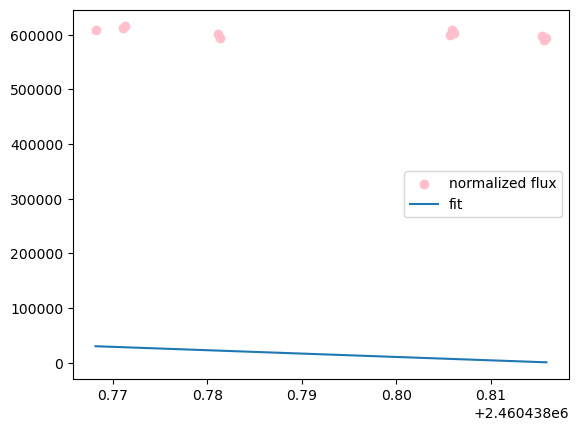

In [39]:
plt.scatter(HV_times, r_HV_UMa_variable, c = 'pink', label = 'normalized flux')
plt.plot(HV_times, HV_fit[:11], label = 'fit')

plt.legend(loc='best')

plt.show()

In [40]:
#r_HV_UMa_variable_norm = r_HY_UMa_variable - r_HV_UMa_ref
j = 0
for item in r_HY_Com_variable:
    item - r_HY_Com_ref[j]
    j+=1

In [41]:
r_HY_Com_variable

[627331.7316015774,
 637439.6497986701,
 634488.6455364404,
 646255.8197532808,
 648694.4527390203,
 642450.015339312,
 639480.1694113555,
 637772.7963891813,
 639362.7137433342,
 629326.8735131731,
 628890.1600153095,
 626689.1002122606]

In [42]:
HY_times_mod = []
for item in HY_times:
    hi_guy = item - 2460438
    HY_times_mod.append(hi_guy)

In [43]:
dummy_y_HY = []
for item in HY_times_mod:
    myest_y = (-333333 * (item - 0.795)) + 635000
    dummy_y_HY.append(myest_y)

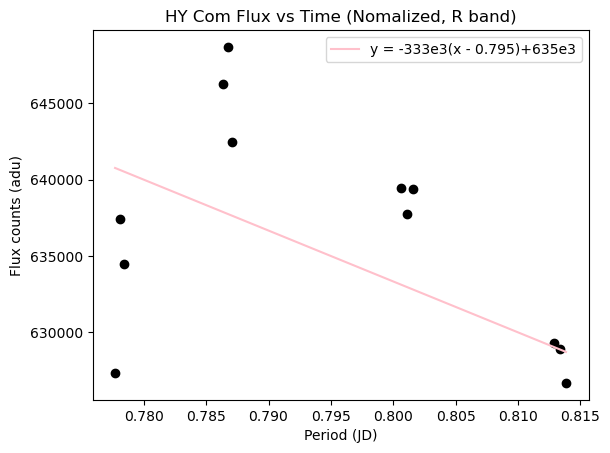

In [158]:
plt.scatter(HY_times_mod, r_HY_Com_variable, c = 'black')
#plt.plot(HY_times, r_HY_Com_variable, c = 'pink')


plt.plot(HY_times_mod, dummy_y_HY, c = 'pink', label = 'y = -333e3(x - 0.795)+635e3')

#plt.scatter(HY_times, r_HY_Com_ref, c = 'blue')
#plt.plot(HY_times, r_HY_Com_ref, c = 'blue')


#plt.yscale('log')
plt.title('HY Com Flux vs Time (Nomalized, R band)')
plt.xlabel('Period (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend()
plt.show()

In [45]:
params_HY, params_covariance = optimize.curve_fit(test_func, HY_times, r_HY_Com_variable, p0=[2, 2])
print(params_HY)

[-6.45460206e+05  2.00419260e+00]


In [46]:
HY_test_func = test_func(HY_times, params_HY[0], 2)
HY_fit = HV_test_func.tolist()

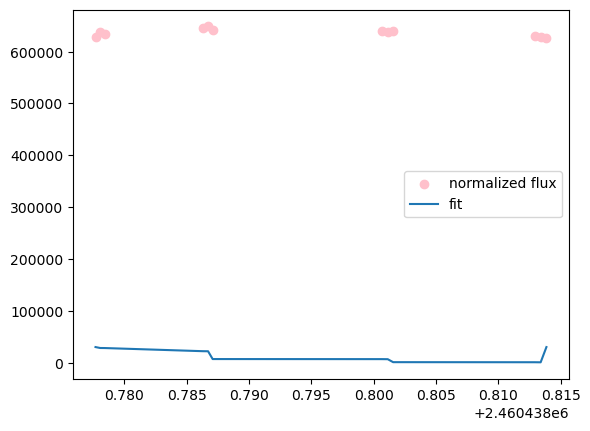

In [47]:
plt.scatter(HY_times, r_HY_Com_variable, c = 'pink', label = 'normalized flux')
plt.plot(HY_times, HY_fit[:12], label = 'fit')

plt.legend(loc='best')

plt.show()

In [48]:
#r_HV_UMa_variable_norm = r_HY_UMa_variable - r_HV_UMa_ref
j = 0
for item in r_TU_UMa_variable:
    item - r_TU_UMa_ref[j]
    j+=1

In [49]:
TU_times_mod = []
for item in TU_times:
    hello_guy = item - 2460438
    TU_times_mod.append(hello_guy)

In [50]:
dummy_y_TU = []
for item in TU_times_mod:
    my_y = (-1100000 * (item - 0.80)) + 1525000
    dummy_y_TU.append(my_y)

In [51]:
dummy_y_TU

[1529962.73140423,
 1529530.4975192994,
 1529106.5391805023,
 1516618.8655607402,
 1516115.2082215995,
 1515611.6784270853,
 1543583.3798442036,
 1543169.3520583212,
 1542768.1827172637]

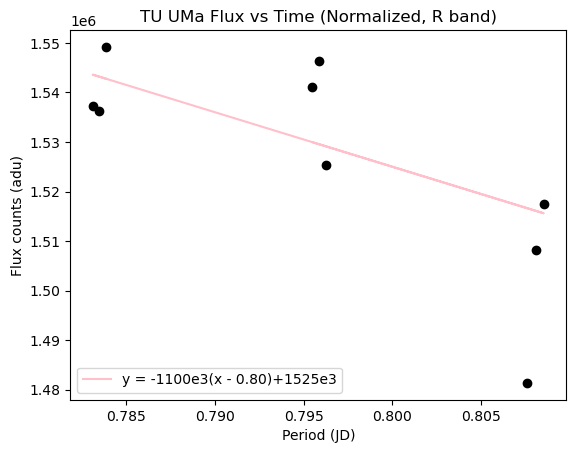

In [157]:
plt.scatter(TU_times_mod, r_TU_UMa_variable, c = 'black')
#plt.plot(TU_times, r_TU_UMa_variable, c = 'pink')

plt.plot(TU_times_mod, dummy_y_TU, c = 'pink', label = 'y = -1100e3(x - 0.80)+1525e3')

#plt.scatter(TU_times, r_TU_UMa_ref, c = 'blue')
#plt.plot(TU_times, r_TU_UMa_ref, c = 'blue')

#plt.yscale('log')
plt.title('TU UMa Flux vs Time (Normalized, R band)')
plt.xlabel('Period (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend()
plt.show()

In [53]:
params_TU, params_covariance = optimize.curve_fit(test_func, TU_times, r_TU_UMa_variable, p0=[2, 2])
print(params_TU)

[-1.66848554e+06  2.30251927e+00]


In [54]:
TU_test_func = test_func(TU_times, params_TU[0], int(params_TU[1]))
TU_fit = TU_test_func.tolist()

In [55]:
len(TU_times)

9

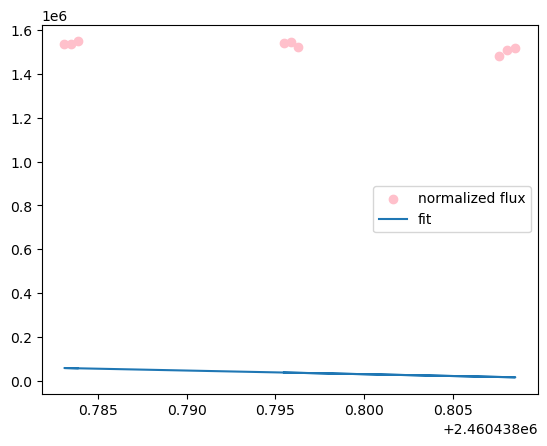

In [56]:
plt.scatter(TU_times, r_TU_UMa_variable, c = 'pink', label = 'normalized flux')
plt.plot(TU_times, TU_fit[:9], label = 'fit')

plt.legend(loc='best')

plt.show()

In [57]:
#Gonna try changing from flux to magnitude
def findmag(flux, exptime):
    mag = -2.5*np.log(np.abs(flux/exptime)) + 10
    return mag

In [58]:
r_HV_UMa_var_mag = []
for element in r_HV_UMa_variable:
    maggie = findmag(flux = element, exptime = 5.0)
    r_HV_UMa_var_mag.append(maggie)

In [59]:
r_HV_UMa_ref_mag_alt = []
for element in r_HV_UMa_ref_alt:
    maggie = findmag(flux = element, exptime = 5.0)
    r_HV_UMa_ref_mag_alt.append(maggie)

In [60]:
r_HV_UMa_ref_mag = []
for element in r_HV_UMa_ref:
    maggie = findmag(flux = element, exptime = 5.0)
    r_HV_UMa_ref_mag.append(maggie)

In [61]:
#Using Max's method
from astroML.time_series import lomb_scargle, lomb_scargle_BIC, lomb_scargle_bootstrap

In [62]:
sigma_func = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
len(sigma_func)

11

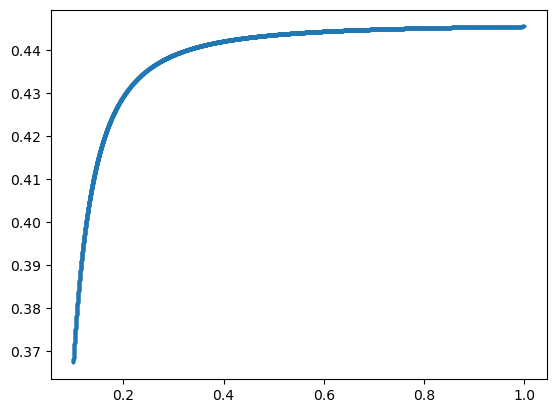

In [63]:
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period


PS = lomb_scargle(HV_times, r_HV_UMa_variable, sigma_func, omega, generalized = True)

plt.scatter(period, PS, s=2)

In [64]:
len(HY_times)

12

In [65]:
new_sigma_func = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
len(new_sigma_func)

12

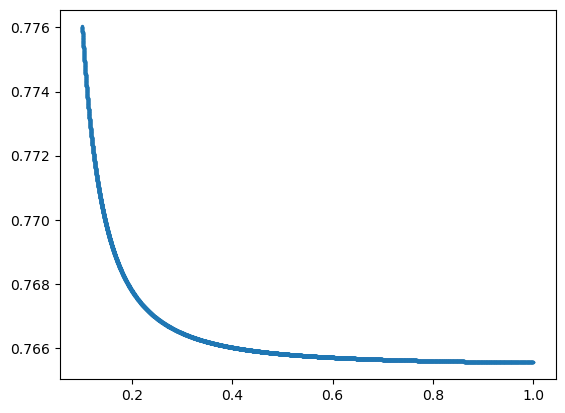

In [66]:
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period


PS = lomb_scargle(HY_times, r_HY_Com_variable, new_sigma_func, omega, generalized = True)

plt.scatter(period, PS, s=2)

In [67]:
len(TU_times)

9

In [68]:
newest_sigma_func = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01])
len(newest_sigma_func)

9

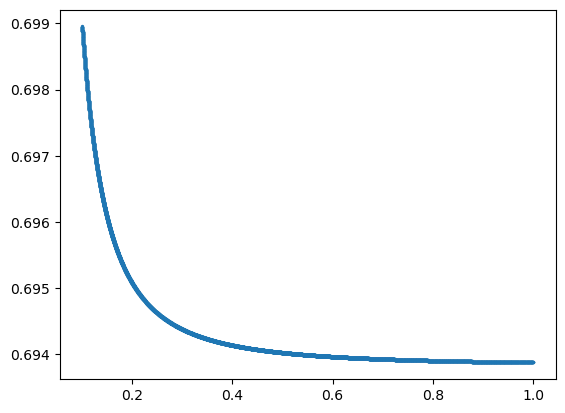

In [69]:
period = 10 ** np.linspace(-1, 0, 10000)
omega = 2 * np.pi / period


PS = lomb_scargle(TU_times, r_TU_UMa_variable, newest_sigma_func, omega, generalized = True)

plt.scatter(period, PS, s=2)

In [70]:
g_HV_UMa_variable=[660234.4619278244, 655242.3840798704, 694794.994809446, 662264.580598617, 677425.3711087876, 671459.0401168861, 636587.9556804367, 633579.501549289, 645820.8900217687, 660384.6167220153, 663316.4849880505, 664263.3426542098]
g_HV_times = [2460438.7715366897, 2460438.7717371527, 2460438.771929861, 2460438.781589815, 2460438.7817849535, 2460438.781988426, 2460438.8049149304, 2460438.8051550924, 2460438.8053899305, 2460438.821922685, 2460438.822192361, 2460438.8224641206]

In [71]:
g_HV_times_mod = []
for time in g_HV_times:
    thing = time - 2460438
    g_HV_times_mod.append(thing)

In [89]:
g_HV_times_mod

[0.7715366897173226,
 0.771737152710557,
 0.7719298610463738,
 0.781589814927429,
 0.7817849535495043,
 0.7819884261116385,
 0.804914930369705,
 0.8051550923846662,
 0.8053899304941297,
 0.8219226850196719,
 0.822192361112684,
 0.8224641205742955]

In [93]:
g_HV_linear = []
for item in g_HV_times_mod:
    myer_y = (-333333 * (item - 0.81)) + 660000
    g_HV_linear.append(myer_y)

In [94]:
g_HV_linear

[672821.0906064557,
 672754.2696755319,
 672690.033627829,
 669470.0522207953,
 669405.0060784831,
 669337.1819589292,
 661695.0215150751,
 661614.967590142,
 661536.6882986003,
 656025.7756343377,
 655935.8836932257,
 655845.2972966083]

In [72]:
g_TU_UMa_variable = [747472.0057634005, 754165.618795441, 755035.1573079226, 740241.6292111244, 744741.7612852798, 745509.9384764807, 707507.916211936, 709699.4784995157, 709032.5676520783]
g_TU_times = [2460438.7842925927, 2460438.78465706, 2460438.7850269675, 2460438.794252778, 2460438.794634838, 2460438.795039236, 2460438.809057523, 2460438.8094898146, 2460438.8098903936]

In [73]:
g_TU_times_mod = []
for time in g_TU_times:
    thing1 = time - 2460438
    g_TU_times_mod.append(thing1)

In [79]:
g_TU_linear = []
for item in TU_times_mod:
    my_g_y = (-2133333 * (item - 0.805)) + 715000
    g_TU_linear.append(my_g_y)

In [74]:
g_HY_Com_variable=[736440.7760158683, 740764.7156796239, 731015.3134272787, 738212.2903048359, 727921.3157407076, 738261.0440734088, 717934.452985728, 720423.8429123923, 719544.2752438538, 705804.7107101597, 706792.2130146343, 711171.062020447]
g_HY_times=[2460438.7789010415, 2460438.7792609953, 2460438.7796197915, 2460438.7875480326, 2460438.787914352, 2460438.7882842594, 2460438.8021089123, 2460438.80250625, 2460438.8029337963, 2460438.8114344906, 2460438.8119083336, 2460438.8123962963]

In [75]:
g_HY_times_mod = []
for time in g_HY_times:
    thing2 = time - 2460438
    g_HY_times_mod.append(thing2)

In [96]:
g_HY_linear = []
for item in g_HY_times_mod:
    myest_g_y = (-900000 * (item - 0.795)) + 724000
    g_HY_linear.append(myest_g_y)

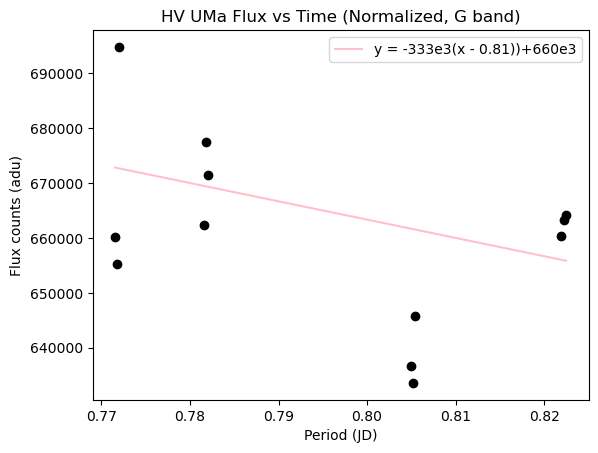

In [156]:
plt.scatter(g_HV_times_mod, g_HV_UMa_variable, c = 'black')
#plt.plot(HV_times, r_HV_UMa_variable, c = 'pink')

plt.plot(g_HV_times_mod, g_HV_linear, c = 'pink', label = 'y = -333e3(x - 0.81))+660e3')

#plt.yscale('log')
plt.title('HV UMa Flux vs Time (Normalized, G band)')
plt.xlabel('Period (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend()
plt.show()

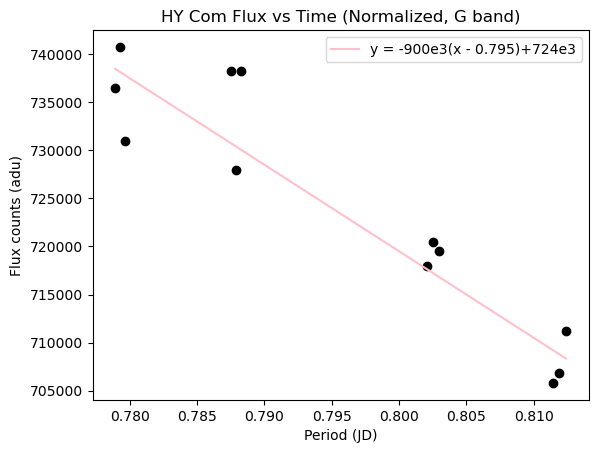

In [155]:
plt.scatter(g_HY_times_mod, g_HY_Com_variable, c = 'black')
#plt.plot(HV_times, r_HV_UMa_variable, c = 'pink')

plt.plot(g_HY_times_mod, g_HY_linear, c = 'pink', label = 'y = -900e3(x - 0.795)+724e3')

#plt.yscale('log')
plt.title('HY Com Flux vs Time (Normalized, G band)')
plt.xlabel('Period (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend()
plt.show()

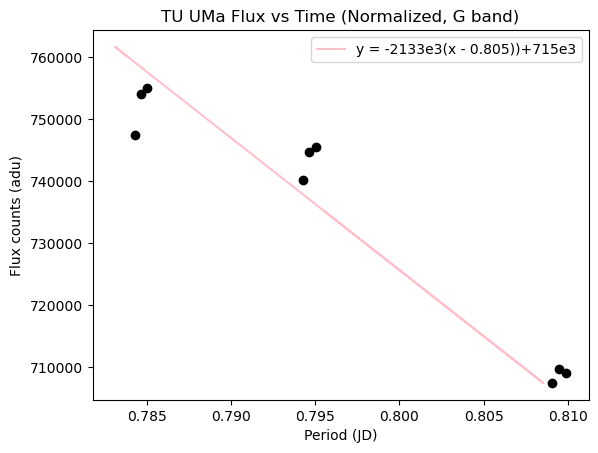

In [154]:
plt.scatter(g_TU_times_mod, g_TU_UMa_variable, c = 'black')
#plt.plot(HV_times, r_HV_UMa_variable, c = 'pink')

plt.plot(TU_times_mod, g_TU_linear, c = 'pink', label = 'y = -2133e3(x - 0.805))+715e3')

#plt.yscale('log')
plt.title('TU UMa Flux vs Time (Normalized, G band)')
plt.xlabel('Period (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend(loc = 'best')
plt.show()

In [117]:
r_period = [4.654, 5.610, 5.610]
r_avg_flux = []
g_period = [6.221, 3.142, 10.134]
g_avg_flux = []

In [118]:
r_HV_avg_flux = sum(r_HV_UMa_variable) / len(r_HV_UMa_variable)
r_avg_flux.append(r_HV_avg_flux)
r_HY_avg_flux = sum(r_HY_Com_variable) / len(r_HY_Com_variable)
r_avg_flux.append(r_HY_avg_flux)
r_TU_avg_flux = sum(r_TU_UMa_variable) / len(r_TU_UMa_variable)
r_avg_flux.append(r_TU_avg_flux)

In [119]:
g_HV_avg_flux = sum(g_HV_UMa_variable) / len(g_HV_UMa_variable)
g_avg_flux.append(g_HV_avg_flux)
g_HY_avg_flux = sum(g_HY_Com_variable) / len(g_HY_Com_variable)
g_avg_flux.append(g_HY_avg_flux)
g_TU_avg_flux = sum(g_TU_UMa_variable) / len(g_TU_UMa_variable)
g_avg_flux.append(g_TU_avg_flux)

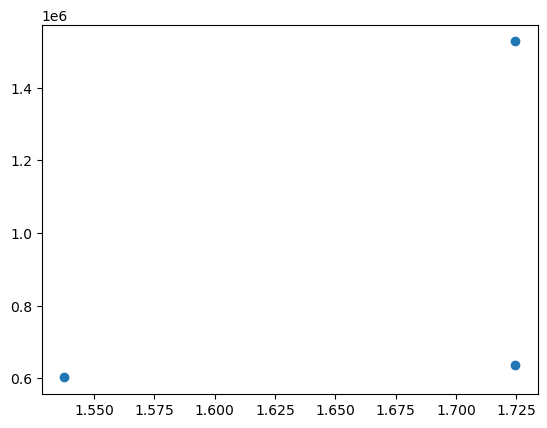

In [127]:
plt.scatter(np.log(r_period), r_avg_flux)
plt.show()

[ 2567781.60598464 -3346534.54325702]


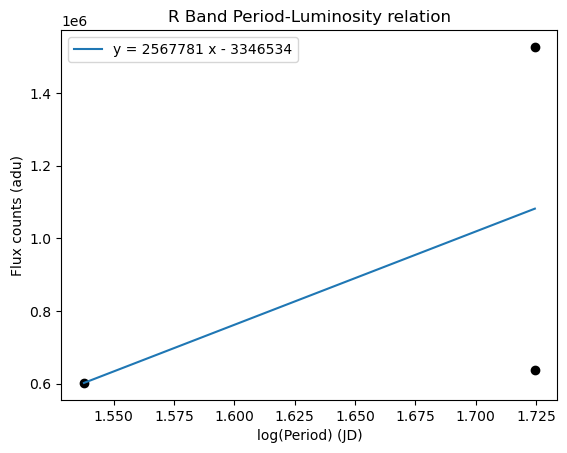

In [153]:
coef = np.polyfit(np.log(r_period), r_avg_flux, 1)
poly1d_fn = np.poly1d(coef)
print(coef)

plt.scatter(np.log(r_period), r_avg_flux, c='black')
plt.plot(np.log(r_period), poly1d_fn(np.log(r_period)), label = 'y = 2567781 x - 3346534')
plt.xlabel('log(Period) (JD)')
plt.ylabel('Flux counts (adu)')
plt.title('R Band Period-Luminosity relation')
plt.legend()

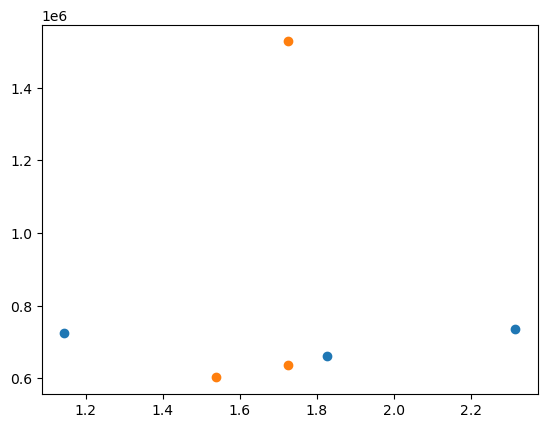

In [161]:
plt.scatter(np.log(g_period), g_avg_flux)
plt.scatter(np.log(r_period), r_avg_flux)

plt.show()

[  2208.3413222  702705.10295473]


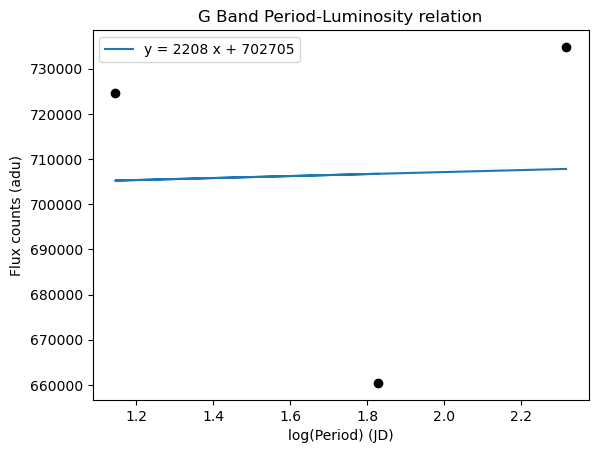

In [151]:
coef = np.polyfit(np.log(g_period), g_avg_flux, 1)
poly1d_fn = np.poly1d(coef)
print(coef)

plt.scatter(np.log(g_period), g_avg_flux, c = 'black')
plt.plot(np.log(g_period), poly1d_fn(np.log(g_period)), label = 'y = 2208 x + 702705')
plt.title('G Band Period-Luminosity relation')
plt.xlabel('log(Period) (JD)')
plt.ylabel('Flux counts (adu)')
plt.legend()